**Note** On my home research cluster using - 14 single core workers, each with ~ 4GB RAM. These are spread across a dual core Xeon server headnode and 6 quad core laptop worker nodes (two workers per machine).

## Checking Existence of Spark Environment Variables

Make sure your notebook is loaded using a PySpark Workspace. If you open up a regular Jupyter workspace the following variables might not exist

In [2]:
spark

In [3]:
sqlContext

### Run the following if you failed to open a notebook in the PySpark Workspace

This will work assuming you are using Spark in the cloud on domino or you might need to configure with your own spark instance if you are working offline

In [7]:
if 'sc' not in locals():
    from pyspark.context import SparkContext
    from pyspark.sql.context import SQLContext
    from pyspark.sql.session import SparkSession
    
    sc = SparkContext(master='spark://192.168.2.1:7077', appName='sparkSQL')
    sqlContext = SQLContext(sc)
    spark = SparkSession(sc)

## Create a utility function to run SQL commands

Instead of typing the same python functions repeatedly, we build a small function where you can just pass your query to get results.

- Remember we are using Spark SQL in PySpark
- We can't run multiple SQL statements in one go (no semi-colon ';' separated SQL statements)
- We can run multi-line SQL queries (but still has to be a single statement)

In [8]:
def run_sql(statement):
    try:
        result = sqlContext.sql(statement)
    except Exception as e:
        print(e.desc, '\n', e.stackTrace)
        return
    return result

In [9]:
tbls = run_sql('show tables')
tbls.toPandas()

Empty DataFrame
Columns: [database, tableName, isTemporary]
Index: []

In [10]:
run_sql('drop table if exists adult')

DataFrame[]

# Loading the Dataset

Below we will use Spark SQL to load in the data and then register it as a Dataframe. So the end result will be a Spark SQL table called `adult` and a Spark Dataframe called `adult_df`. 

This is an example of the flexibility in Spark in that you could do lots of you ETL and data wrangling using either Spark SQL or Dataframes and pyspark. Most of the time it's a case of using whatever you are most comfortable with. 

When you get more advanced then you might looking the pro's and con's of each and when you might favour one or the other (or operating direclty on RDD's), [here](https://databricks.com/blog/2016/07/14/a-tale-of-three-apache-spark-apis-rdds-dataframes-and-datasets.html) is a good article on the issues. For now, no need to overthink it!

## Creating the DataFrame

In this section, we will be creating a spark dataframe from the `adult` dataset which is easier work with when building machine learning models.

To get started, first make sure you have already uploaded the `adult.data.csv` CSV file and it is present in the same directory as the notebook.

Once you have done this, please remember to execute the following code to build the dataframe which can also be accessed as a table using spark SQL which we will see shortly.

In [11]:
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import DoubleType, IntegerType, StringType

# File location and type
file_location_adult = "./adult.data.csv"
file_type = "csv"

# CSV options
infer_schema = "false"
first_row_is_header = "false"
delimiter = ","

# define the schema based on the dataset dictionary
# this is available here: https://archive.ics.uci.edu/ml/datasets/adult
schema = StructType([
      StructField('age', DoubleType()),
      StructField('workclass', StringType()),
      StructField('fnlwgt', DoubleType()),
      StructField('education', StringType()),
      StructField('education_num', DoubleType()),
      StructField('marital_status', StringType()),
      StructField('occupation', StringType()),
      StructField('relationship', StringType()),
      StructField('race', StringType()),
      StructField('sex', StringType()),
      StructField('capital_gain', DoubleType()),
      StructField('capital_loss', DoubleType()),
      StructField('hours_per_week', DoubleType()),
      StructField('native_country', StringType()),
      StructField('income', StringType())
])


# The applied options are for CSV files. For other file types, these will be ignored.
adult_df = (spark.read.format(file_type) 
                    .schema(schema)
                    .option("inferSchema", infer_schema) 
                    .option("header", first_row_is_header) 
                    .option("sep", delimiter) 
                    .load(file_location_adult))

### Viewing the dataframe schemas

We can take a look at the schemas of our potential dataset

In [12]:
print('Adult Dataset Schema')
adult_df.printSchema()

Adult Dataset Schema
root
 |-- age: double (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: double (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: double (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: double (nullable = true)
 |-- capital_loss: double (nullable = true)
 |-- hours_per_week: double (nullable = true)
 |-- native_country: string (nullable = true)
 |-- income: string (nullable = true)



In [13]:
adult_df.registerTempTable("adult")
tbls = run_sql('show tables')
tbls.toPandas()

database tableName  isTemporary
0              adult         True

# Viewing the Dataset

In [14]:
df = run_sql("SELECT * FROM adult LIMIT 5")
df.toPandas()

age          workclass    fnlwgt   education  education_num  \
0  39.0          State-gov   77516.0   Bachelors           13.0   
1  50.0   Self-emp-not-inc   83311.0   Bachelors           13.0   
2  38.0            Private  215646.0     HS-grad            9.0   
3  53.0            Private  234721.0        11th            7.0   
4  28.0            Private  338409.0   Bachelors           13.0   

        marital_status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capital_gain  capital_loss  hours_per_week  native_country  income  
0        2174.0           0.0            40.0   United-States   <=50K  
1           0.0           0.0            13.0   United-States   <=50K  
2           0.0           0.0            40.0   United-States   <=50K  
3           0.0           0.0            40.0   United-States   <=50K  
4           0.0           0.0            40.0            Cuba   <=50K

If you are more comfortable with SQL then as you can see below, its very easy to just get going with writing standard SQL type code to analyse your data, do data wrangling and create new dataframes. 

In [15]:
df.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             5 non-null      float64
 1   workclass       5 non-null      object 
 2   fnlwgt          5 non-null      float64
 3   education       5 non-null      object 
 4   education_num   5 non-null      float64
 5   marital_status  5 non-null      object 
 6   occupation      5 non-null      object 
 7   relationship    5 non-null      object 
 8   race            5 non-null      object 
 9   sex             5 non-null      object 
 10  capital_gain    5 non-null      float64
 11  capital_loss    5 non-null      float64
 12  hours_per_week  5 non-null      float64
 13  native_country  5 non-null      object 
 14  income          5 non-null      object 
dtypes: float64(6), object(9)
memory usage: 728.0+ bytes


In [16]:
result = run_sql(
  """
  SELECT 
    education,
    SUM(1) as n,
    ROUND(AVG(if(LTRIM(marital_status) LIKE 'Married-%',1,0)),2) as married_rate,
    ROUND(AVG(if(lower(marital_status) LIKE '%widow%',1,0)),2) as widow_rate,
    ROUND(AVG(if(LTRIM(marital_status) = 'Divorced',1,0)),2) as divorce_rate,
    ROUND(AVG(if(LTRIM(marital_status) = 'Separated',1,0)),2) as separated_rate,
    ROUND(AVG(if(LTRIM(marital_status) = 'Never-married',1,0)),2) as bachelor_rate
  FROM 
    adult 
  GROUP BY 1
  ORDER BY n DESC
  """)
result.toPandas()

education      n  married_rate  widow_rate  divorce_rate  \
0         HS-grad  10501          0.47        0.04          0.15   
1    Some-college   7291          0.40        0.02          0.15   
2       Bachelors   5355          0.53        0.02          0.10   
3         Masters   1723          0.59        0.02          0.14   
4       Assoc-voc   1382          0.51        0.03          0.17   
5            11th   1175          0.32        0.03          0.11   
6      Assoc-acdm   1067          0.44        0.02          0.19   
7            10th    933          0.39        0.04          0.13   
8         7th-8th    646          0.58        0.10          0.11   
9     Prof-school    576          0.72        0.01          0.10   
10            9th    514          0.46        0.04          0.12   
11           12th    433          0.32        0.02          0.09   
12      Doctorate    413          0.71        0.02          0.08   
13        5th-6th    333          0.58        0.04          0.06   
14        1st-4th    168          0.55        0.10          0.06   
15      Preschool     51          0.47        0.06          0.02   

    separated_rate  bachelor_rate  
0             0.04           0.29  
1             0.03           0.40  
2             0.02           0.34  
3             0.01           0.23  
4             0.03           0.26  
5             0.04           0.50  
6             0.03           0.32  
7             0.05           0.39  
8             0.04           0.17  
9             0.01           0.16  
10            0.06           0.30  
11            0.03           0.54  
12            0.02           0.18  
13            0.05           0.27  
14            0.05           0.23  
15            0.02           0.43

You can easily register dataframes as a table for Spark SQL too. So this way you can easily move between Dataframes and Spark SQL as needed.  

In [17]:
# register the df we just made as a table for spark sql
sqlContext.registerDataFrameAsTable(result, "result")
tbls = run_sql('show tables')
tbls.toPandas()

database tableName  isTemporary
0              adult         True
1             result         True

In [18]:
run_sql("SELECT * FROM result").limit(5).toPandas()

education      n  married_rate  widow_rate  divorce_rate  \
0        HS-grad  10501          0.47        0.04          0.15   
1   Some-college   7291          0.40        0.02          0.15   
2      Bachelors   5355          0.53        0.02          0.10   
3        Masters   1723          0.59        0.02          0.14   
4      Assoc-voc   1382          0.51        0.03          0.17   

   separated_rate  bachelor_rate  
0            0.04           0.29  
1            0.03           0.40  
2            0.02           0.34  
3            0.01           0.23  
4            0.03           0.26

# Your Turn: Q1
### Write some Spark SQL to get the top 'bachelor_rate' by 'education' group?

In [19]:
### Q1 Answer ###

bachelor_rate = run_sql(
  """
  SELECT 
    MAX(bachelor_rate), education
  FROM 
    result
  GROUP BY education
  ORDER BY MAX(bachelor_rate) DESC
  """)
bachelor_rate.toPandas()

max(bachelor_rate)      education
0                 0.54           12th
1                 0.50           11th
2                 0.43      Preschool
3                 0.40   Some-college
4                 0.39           10th
5                 0.34      Bachelors
6                 0.32     Assoc-acdm
7                 0.30            9th
8                 0.29        HS-grad
9                 0.27        5th-6th
10                0.26      Assoc-voc
11                0.23        Masters
12                0.23        1st-4th
13                0.18      Doctorate
14                0.17        7th-8th
15                0.16    Prof-school

# Spark DataFrames
Below we will create our DataFrame from the SQL table and do some similar analysis as we did with Spark SQL but using the DataFrames API.

In [20]:
# register a df from the sql df
adult_df = spark.table("adult")
cols = adult_df.columns # this will be used much later in the notebook, ignore for now
print(type(adult_df))
print(cols)

<class 'pyspark.sql.dataframe.DataFrame'>
['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income']


In [21]:
# look at df schema
adult_df.printSchema()

root
 |-- age: double (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: double (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: double (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: double (nullable = true)
 |-- capital_loss: double (nullable = true)
 |-- hours_per_week: double (nullable = true)
 |-- native_country: string (nullable = true)
 |-- income: string (nullable = true)



Be careful with `toPandas()` since it dumps the entire spark dataframe (which might be distributed) in your local system which might end up crashing your notebook if your resources can't handle it. A good option is always to use `limit()` to limit the rows and then take a look at the data.

In [22]:
adult_df.limit(5).toPandas()

age          workclass    fnlwgt   education  education_num  \
0  39.0          State-gov   77516.0   Bachelors           13.0   
1  50.0   Self-emp-not-inc   83311.0   Bachelors           13.0   
2  38.0            Private  215646.0     HS-grad            9.0   
3  53.0            Private  234721.0        11th            7.0   
4  28.0            Private  338409.0   Bachelors           13.0   

        marital_status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capital_gain  capital_loss  hours_per_week  native_country  income  
0        2174.0           0.0            40.0   United-States   <=50K  
1           0.0           0.0            13.0   United-States   <=50K  
2           0.0           0.0            40.0   United-States   <=50K  
3           0.0           0.0            40.0   United-States   <=50K  
4           0.0           0.0            40.0            Cuba   <=50K

## Using the DataFrame API for computations

By now, you have already learnt how to leverage the Spark DataFrame API to wrangle, aggregate, filter and transform data. Following is a depiction on our dataset showcasing the divorced date based on occupation

In [23]:
# import what we will need
from pyspark.sql.functions import when, col, mean, desc, round

# wrangle the data a bit
df_result = adult_df.select(
  adult_df['occupation'], 
  # create a 1/0 type col on the fly
  when( col('marital_status') == ' Divorced' , 1 ).otherwise(0).alias('is_divorced')
)
# do grouping (and a round)
df_result = df_result.groupBy('occupation').agg(round(mean('is_divorced'),2).alias('divorced_rate'))
# do ordering
df_result = df_result.orderBy(desc('divorced_rate'))
# show results
df_result.show(5)

+----------------+-------------+
|      occupation|divorced_rate|
+----------------+-------------+
|    Adm-clerical|         0.22|
| Priv-house-serv|         0.19|
|    Tech-support|         0.15|
|   Other-service|         0.15|
| Exec-managerial|         0.15|
+----------------+-------------+
only showing top 5 rows



In [24]:
type(df_result)

pyspark.sql.dataframe.DataFrame

In [25]:
type(adult_df)

pyspark.sql.dataframe.DataFrame

As you can see the dataframes api is a bit more verbose then just expressing what you want to do in standard SQL.

But some prefer it and might be more used to it, and there could be cases where expressing what you need to do might just be better using the DataFrame API if it is too complicated for a simple SQL expression for example of maybe involves recursion of some type.

# Your Turn: Q2
### Write some pyspark to get the top 'bachelor_rate' by 'education' group using DataFrame operations?

In [26]:
result

DataFrame[education: string, n: bigint, married_rate: double, widow_rate: double, divorce_rate: double, separated_rate: double, bachelor_rate: double]

In [27]:
### Q2 Answer ###
from pyspark.sql import functions as F

bachelor_rate = result.groupBy('education').agg(F.max('bachelor_rate'))
bachelor_rate = bachelor_rate.orderBy(desc('max(bachelor_rate)'))

In [28]:
bachelor_rate.show()

+-------------+------------------+
|    education|max(bachelor_rate)|
+-------------+------------------+
|         12th|              0.54|
|         11th|               0.5|
|    Preschool|              0.43|
| Some-college|               0.4|
|         10th|              0.39|
|    Bachelors|              0.34|
|   Assoc-acdm|              0.32|
|          9th|               0.3|
|      HS-grad|              0.29|
|      5th-6th|              0.27|
|    Assoc-voc|              0.26|
|      1st-4th|              0.23|
|      Masters|              0.23|
|    Doctorate|              0.18|
|      7th-8th|              0.17|
|  Prof-school|              0.16|
+-------------+------------------+



## Explore & Visualize Data
It's very easy to convert your Spark DataFrame into a Pandas dataframe and then continue to analyse or plot as you might normally.  We have depicted the same in several example above. You can also use the `collect()` function if needed instead of `toPandas()` but you would need to call a `pandas.DataFrame` on the result.

Obviously if you try to build a huge pandas DataFrame then you will run into issues, so usually the best practice is to only collect aggregated or sampled data into a Pandas df.

In [29]:
import pandas as pd

# do some analysis
result = run_sql(
  """
  SELECT 
    occupation,
    AVG(IF(income = ' >50K',1,0)) as plus_50k
  FROM 
    adult 
  GROUP BY 1
  ORDER BY 2 DESC
  """)

# collect results into a pandas df
df_pandas = pd.DataFrame(
  result.collect(),
  columns=result.schema.names
)

df_pandas.head()

occupation  plus_50k
0   Exec-managerial  0.484014
1    Prof-specialty  0.449034
2   Protective-serv  0.325116
3      Tech-support  0.304957
4             Sales  0.269315

In [30]:
# or just use a one-liner for a pandas df
df_pandas = result.toPandas()
df_pandas.head()

occupation  plus_50k
0   Exec-managerial  0.484014
1    Prof-specialty  0.449034
2   Protective-serv  0.325116
3      Tech-support  0.304957
4             Sales  0.269315

In [31]:
df_pandas.describe()

plus_50k
count  15.000000
mean    0.197354
std     0.143994
min     0.006711
25%     0.107373
50%     0.134483
75%     0.287136
max     0.484014

In [32]:
df_pandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   occupation  15 non-null     object 
 1   plus_50k    15 non-null     float64
dtypes: float64(1), object(1)
memory usage: 368.0+ bytes


Here we will just do some very basic plotting to show how you might collect what you are interested in into a Pandas DF and then just plot any way you normally would.

For simplicity we are going to use the plotting functionality built into pandas (you could make this as pretty as you want). 

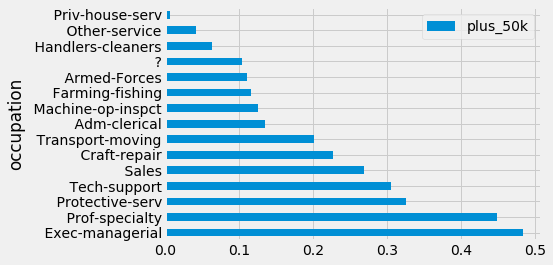

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

# feel free to chose your own style!
plt.style.use('fivethirtyeight')

# get simple plot on the pandas data
df_pandas.plot(kind='barh', x='occupation', y='plus_50k')

You can also easily get summary stats on a Spark DataFrame like below. [Here](https://databricks.com/blog/2015/06/02/statistical-and-mathematical-functions-with-dataframes-in-spark.html) is a nice blog post that has more examples.

So this is an example of when you might want to move from Spark SQL into using DataFrames API as being able to just call `describe()` on the Spark DF is easier then trying to do the equivalent in Spark SQL.

In [34]:
# describe df
adult_df.select(adult_df['age'], adult_df['education_num']).describe().show()

+-------+------------------+-----------------+
|summary|               age|    education_num|
+-------+------------------+-----------------+
|  count|             32561|            32561|
|   mean| 38.58164675532078| 10.0806793403151|
| stddev|13.640432553581356|2.572720332067397|
|    min|              17.0|              1.0|
|    max|              90.0|             16.0|
+-------+------------------+-----------------+



## ML Pipeline - Logistic Regression vs Random Forest

Below we will create two Spark ML Pipelines - one that fits a logistic regression and one that fits a random forest. We will then compare the performance of each.

We will be using Spark MLlib. Here are some interesting facts about the same and you can read up more in the [official docs](https://spark.apache.org/docs/latest/ml-guide.html)

#### What is MLlib?
MLlib is Spark’s machine learning (ML) library. Its goal is to make practical machine learning scalable and easy. At a high level, it provides tools such as:

- ML Algorithms: common learning algorithms such as classification, regression, clustering, and collaborative filtering
- Featurization: feature extraction, transformation, dimensionality reduction, and selection
- Pipelines: tools for constructing, evaluating, and tuning ML Pipelines
- Persistence: saving and load algorithms, models, and Pipelines
- Utilities: linear algebra, statistics, data handling, etc.

Some important points to remember.

#### The MLlib RDD-based API is now in maintenance mode.
As of Spark 2.0, the RDD-based APIs in the `spark.mllib` package have entered maintenance mode. The primary Machine Learning API for Spark is now the DataFrame-based API in the `spark.ml` package.

#### Why is MLlib switching to the DataFrame-based API?
DataFrames provide a more user-friendly API than RDDs. The many benefits of DataFrames include Spark Datasources, SQL/DataFrame queries, Tungsten and Catalyst optimizations, and uniform APIs across languages.
The DataFrame-based API for MLlib provides a uniform API across ML algorithms and across multiple languages.
DataFrames facilitate practical ML Pipelines, particularly feature transformations. See the Pipelines guide for details.

#### What is “Spark ML”?
“Spark ML” is not an official name but occasionally used to refer to the MLlib DataFrame-based API. This is majorly due to the org.apache.spark.ml Scala package name used by the DataFrame-based API, and the “Spark ML Pipelines” term we used initially to emphasize the pipeline concept.

#### Is MLlib deprecated?
No. MLlib includes both the RDD-based API and the DataFrame-based API. The RDD-based API is now in maintenance mode. But neither API is deprecated, nor MLlib as a whole.

In [35]:
import pyspark
pyspark.__version__

'2.4.5'

In [36]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler

categoricalColumns = ["workclass", "education", "marital_status", "occupation", "relationship", "race", "sex", "native_country"]
stages = [] # stages in our Pipeline

for categoricalCol in categoricalColumns:
    # Category Indexing with StringIndexer
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index")
    # Use OneHotEncoder to convert categorical variables into binary SparseVectors
    # encoder = OneHotEncoderEstimator(inputCol=categoricalCol + "Index", outputCol=categoricalCol + "classVec")
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    # Add stages.  These are not run here, but will run all at once later on.
    stages += [stringIndexer, encoder]

In [37]:
# Convert label into label indices using the StringIndexer
label_stringIdx = StringIndexer(inputCol="income", outputCol="label")
stages += [label_stringIdx]

In [38]:
# Transform all features into a vector using VectorAssembler
numericCols = ["age", "fnlwgt", "education_num", "capital_gain", "capital_loss", "hours_per_week"]
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [39]:
# Create a Pipeline.
pipeline = Pipeline(stages=stages)

# Run the feature transformations.
#  - fit() computes feature statistics as needed.
#  - transform() actually transforms the features.
pipelineModel = pipeline.fit(adult_df)
dataset = pipelineModel.transform(adult_df)

# Keep relevant columns
selectedcols = ["label", "features"] + cols
dataset = dataset.select(selectedcols)
dataset.limit(10).toPandas()

label                                           features   age  \
0    0.0  (0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...  39.0   
1    0.0  (0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  50.0   
2    0.0  (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...  38.0   
3    0.0  (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  53.0   
4    0.0  (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  28.0   
5    0.0  (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  37.0   
6    0.0  (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  49.0   
7    1.0  (0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...  52.0   
8    1.0  (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  31.0   
9    1.0  (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  42.0   

           workclass    fnlwgt   education  education_num  \
0          State-gov   77516.0   Bachelors           13.0   
1   Self-emp-not-inc   83311.0   Bachelors           13.0   
2            Private  215646.0     HS-grad            9.0   
3            Private  234721.0        11th            7.0   
4            Private  338409.0   Bachelors           13.0   
5            Private  284582.0     Masters           14.0   
6            Private  160187.0         9th            5.0   
7   Self-emp-not-inc  209642.0     HS-grad            9.0   
8            Private   45781.0     Masters           14.0   
9            Private  159449.0   Bachelors           13.0   

           marital_status          occupation    relationship    race  \
0           Never-married        Adm-clerical   Not-in-family   White   
1      Married-civ-spouse     Exec-managerial         Husband   White   
2                Divorced   Handlers-cleaners   Not-in-family   White   
3      Married-civ-spouse   Handlers-cleaners         Husband   Black   
4      Married-civ-spouse      Prof-specialty            Wife   Black   
5      Married-civ-spouse     Exec-managerial            Wife   White   
6   Married-spouse-absent       Other-service   Not-in-family   Black   
7      Married-civ-spouse     Exec-managerial         Husband   White   
8           Never-married      Prof-specialty   Not-in-family   White   
9      Married-civ-spouse     Exec-managerial         Husband   White   

       sex  capital_gain  capital_loss  hours_per_week  native_country  income  
0     Male        2174.0           0.0            40.0   United-States   <=50K  
1     Male           0.0           0.0            13.0   United-States   <=50K  
2     Male           0.0           0.0            40.0   United-States   <=50K  
3     Male           0.0           0.0            40.0   United-States   <=50K  
4   Female           0.0           0.0            40.0            Cuba   <=50K  
5   Female           0.0           0.0            40.0   United-States   <=50K  
6   Female           0.0           0.0            16.0         Jamaica   <=50K  
7     Male           0.0           0.0            45.0   United-States    >50K  
8   Female       14084.0           0.0            50.0   United-States    >50K  
9     Male        5178.0           0.0            40.0   United-States    >50K

In [40]:
### Randomly split data into training and test sets. set seed for reproducibility
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed=100)
print(trainingData.count())
print(testData.count())

22838
9723


In [41]:
from pyspark.sql.functions import avg

# get the rate of the positive outcome from the training data to use as a threshold in the model
training_data_positive_rate = trainingData.select(avg(trainingData['label'])).collect()[0][0] 

print("Positive rate in the training data is {}".format(training_data_positive_rate))

Positive rate in the training data is 0.23933794552938087


# Logistic Regression - Training

In [42]:
from pyspark.ml.classification import LogisticRegression

# Create initial LogisticRegression model
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)

# set threshold for the probability above which to predict a 1
lr.setThreshold(training_data_positive_rate)
# lr.setThreshold(0.5) # could use this if knew you had balanced data

# Train model with Training Data
lrModel = lr.fit(trainingData)

# get training summary used for eval metrics and other params
lrTrainingSummary = lrModel.summary

# Find the best model threshold if you would like to use that instead of the empirical positve rate
fMeasure = lrTrainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
lrBestThreshold = (fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)'])
                           .select('threshold').head()['threshold'])
  
print("Best threshold based on model performance on training data is {}".format(lrBestThreshold))

Best threshold based on model performance on training data is 0.33346302421886326


# Logistic Regression - Predictions

In [43]:
# check current model prediction threshold
lrModel._java_obj.getThreshold()

0.23933794552938087

In [44]:
# rebuild model with optimal threshold from training
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)

# set threshold for the probability above which to predict a 1
lr.setThreshold(lrBestThreshold)
# lr.setThreshold(0.5) # could use this if knew you had balanced data

# Train model with Training Data
lrModel = lr.fit(trainingData)

lrModel._java_obj.getThreshold()

0.33346302421886326

In [45]:
# make predictions on test data
lrPredictions = lrModel.transform(testData)

# display predictions
lrPredictions.select("label", "prediction", "probability").limit(10).toPandas()

label  prediction                                probability
0    0.0         0.0   [0.6923453279519433, 0.3076546720480568]
1    0.0         1.0  [0.6211553145296423, 0.37884468547035766]
2    0.0         1.0   [0.6584529417752994, 0.3415470582247006]
3    0.0         1.0  [0.6582662002284263, 0.34173379977157375]
4    0.0         1.0   [0.6150342380572296, 0.3849657619427704]
5    0.0         1.0  [0.5398608213408302, 0.46013917865916976]
6    0.0         1.0  [0.6004473238924508, 0.39955267610754913]
7    0.0         1.0   [0.589862498197214, 0.41013750180278596]
8    0.0         1.0   [0.5824187454881695, 0.4175812545118305]
9    0.0         1.0    [0.5920153502136111, 0.407984649786389]

# Gradient Boosting Machines (GBM) - Training

Here you will train your own GBM Classifier and make predictions

# Your Turn: Q3
### Train a GBTClassifier on the training data, call the trained model 'gbModel'
- Note: You don't need to set a prediction threshold here, just try training a vanilla GBM model

In [46]:
# adapted from https://spark.apache.org/docs/latest/ml-classification-regression.html#gradient-boosted-tree-classifier

from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10)
gbModel = gbt.fit(trainingData)

# Your Turn: Q4
### Get predictions on the test data for your GBTClassifier. Call the predictions df 'gbPredictions' and display the first 10 records

In [47]:
# make predictions on test data
gbPredictions = gbModel.transform(testData)

# display predictions
gbPredictions.select("label", "prediction", "probability").limit(10).toPandas()

label  prediction                                probability
0    0.0         0.0  [0.7992953930959711, 0.20070460690402891]
1    0.0         0.0  [0.7537171879849179, 0.24628281201508206]
2    0.0         0.0  [0.7537171879849179, 0.24628281201508206]
3    0.0         0.0  [0.7537171879849179, 0.24628281201508206]
4    0.0         0.0   [0.5629204299572179, 0.4370795700427821]
5    0.0         0.0   [0.5629204299572179, 0.4370795700427821]
6    0.0         0.0  [0.5916948245650491, 0.40830517543495093]
7    0.0         0.0  [0.5916948245650491, 0.40830517543495093]
8    0.0         0.0  [0.6753953970434889, 0.32460460295651106]
9    0.0         0.0  [0.6753953970434889, 0.32460460295651106]

# Model Performance Evaluation

Without evaluation of how our models perform, there is no way for us to find out which model might be better or more suitable to solving a specific problem. Let's spend some time evaluating our models.

# Your Turn: Q5 - Logistic Regression - Evaluation

### Complete the `print_performance_metrics()` function below to also include measures of F1, Precision, Recall, False Positive Rate and True Positive Rate.

In [57]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics

def print_performance_metrics(predictions):
    # Evaluate model
    evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
    auc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
    aupr = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"})
    print("auc = {:.2f}".format(auc))
    print("aupr = {:.2f}".format(aupr))

    # get rdd of predictions and labels for mllib eval metrics
    predictionAndLabels = predictions.select("prediction","label").rdd

    # Instantiate metrics objects
    binary_metrics = BinaryClassificationMetrics(predictionAndLabels)
    multi_metrics = MulticlassMetrics(predictionAndLabels)

    # Area under precision-recall curve
    print("Area under PR = {:.2f}".format(binary_metrics.areaUnderPR))
    # Area under ROC curve
    print("Area under ROC = {:.2f}".format(binary_metrics.areaUnderROC))
    # Accuracy
    print("Accuracy = {:.2f}".format(multi_metrics.accuracy))
    # Confusion Matrix
    print(multi_metrics.confusionMatrix())

    ### Question 5.1 Answer ###

    # F1
    print("F1 = {:.2f}".format(multi_metrics.fMeasure()))
    # Precision
    print("Precision = {:.2f}".format(multi_metrics.precision()))
    # Recall
    print("Recall = {:.2f}".format(multi_metrics.recall()))
    # FPR
    print("FPR = {:.2f}".format(multi_metrics.falsePositiveRate(1.0)))
    # TPR
    print("TPR = {:.2f}".format(multi_metrics.truePositiveRate(1.0)))
  
  
print_performance_metrics(lrPredictions)

auc = 0.90
aupr = 0.76
Area under PR = 0.58
Area under ROC = 0.81
Accuracy = 0.83
DenseMatrix([[6282., 1066.],
             [ 581., 1794.]])
F1 = 0.83
Precision = 0.83
Recall = 0.83
FPR = 0.15
TPR = 0.76


# Your Turn: Q6 - GBM - Evaluation

### Now use the `print_performance_metrics()` function to evaluate the performance of the GBM model and compare the results

In [58]:
print_performance_metrics(gbPredictions)

auc = 0.90
aupr = 0.78
Area under PR = 0.65
Area under ROC = 0.75
Accuracy = 0.85
DenseMatrix([[6939.,  409.],
             [1036., 1339.]])
F1 = 0.85
Precision = 0.85
Recall = 0.85
FPR = 0.06
TPR = 0.56


# Cross Validation

For each model you can run the below comand to see its params and a brief explanation of each.

In [59]:
print(lr.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features, current: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: label)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. The

In [61]:
print(gbt.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

# Logistic Regression - Param Grid

In [68]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
lrParamGrid = (ParamGridBuilder()
               .addGrid(lr.regParam, [0.01, 0.5, 2.0])
               .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
               .addGrid(lr.maxIter, [2, 5, 10])
               .build())

In [69]:
print('Total Models (with all hyperparameter combinations):', len(lrParamGrid))

Total Models (with all hyperparameter combinations): 27


# Your Turn: Q7: GBM - Param Grid
Build out a param grid for the gb model, call it 'gbParamGrid'.

In [70]:
# Create ParamGrid for Cross Validation
gbParamGrid = (ParamGridBuilder()
               .addGrid(gbt.maxDepth, [5, 10, 20])
               .addGrid(gbt.maxIter, [5, 10, 20])
               .addGrid(gbt.stepSize, [0.001, 0.01, 0.1])
               .build())

In [71]:
print('Total Models (with all hyperparameter combinations):', len(gbParamGrid))

Total Models (with all hyperparameter combinations): 27


# Logistic Regression - Perform Cross Validation

In [72]:
# set up an evaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

# Create CrossValidator
lrCv = CrossValidator(estimator=lr, estimatorParamMaps=lrParamGrid, evaluator=evaluator, numFolds=3)

# Run cross validations
lrCvModel = lrCv.fit(trainingData)
# this will likely take a fair amount of time because of the amount of models that we're creating and testing

In [73]:
# look at best params from the CV
print(lrCvModel.bestModel._java_obj.getRegParam())
print(lrCvModel.bestModel._java_obj.getElasticNetParam())
print(lrCvModel.bestModel._java_obj.getMaxIter())

0.01
0.0
10


In [74]:
lrCvModel.bestModel._java_obj.extractParamMap()

JavaObject id=o21945

# Your Turn: Q8: GBM - Perform Cross Validation
- Perform cross validation of params on your 'gb' model.
- Print out the best params you found.

In [75]:
# Create CrossValidator
# set up an evaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

# Create CrossValidator
gbtCv = CrossValidator(estimator=gbt, estimatorParamMaps=gbParamGrid, evaluator=evaluator, numFolds=3)

# Run cross validations
gbtCvModel = gbtCv.fit(trainingData)

# this will likely take a fair amount of time because of the amount of models that we're creating and testing

In [78]:
# look at best params from the CV
print(gbtCvModel.bestModel._java_obj.getMaxDepth())
print(gbtCvModel.bestModel._java_obj.getMaxIter())
print(gbtCvModel.bestModel._java_obj.getStepSize())

5
20
0.1


# Logistic Regression - CV Model Predict

In [79]:
# Use test set to measure the accuracy of our model on new data
lrCvPredictions = lrCvModel.transform(testData)

lrCvPredictions.limit(10).toPandas()

label                                           features   age workclass  \
0    0.0  (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...  26.0   Private   
1    0.0  (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...  30.0   Private   
2    0.0  (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...  31.0   Private   
3    0.0  (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...  32.0   Private   
4    0.0  (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...  39.0   Private   
5    0.0  (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...  47.0   Private   
6    0.0  (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...  50.0   Private   
7    0.0  (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...  51.0   Private   
8    0.0  (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...  60.0   Private   
9    0.0  (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...  61.0   Private   

     fnlwgt education  education_num       marital_status       occupation  \
0   58426.0   HS-grad            9.0   Married-civ-spouse   Prof-specialty   
1   83253.0   HS-grad            9.0   Married-civ-spouse   Prof-specialty   
2   62374.0   HS-grad            9.0   Married-civ-spouse   Prof-specialty   
3   32732.0   HS-grad            9.0   Married-civ-spouse   Prof-specialty   
4  181705.0   HS-grad            9.0   Married-civ-spouse   Prof-specialty   
5   76612.0   HS-grad            9.0   Married-civ-spouse   Prof-specialty   
6   81548.0   HS-grad            9.0   Married-civ-spouse   Prof-specialty   
7   95469.0   HS-grad            9.0   Married-civ-spouse   Prof-specialty   
8  198727.0   HS-grad            9.0   Married-civ-spouse   Prof-specialty   
9  128230.0   HS-grad            9.0   Married-civ-spouse   Prof-specialty   

  relationship    race    sex  capital_gain  capital_loss  hours_per_week  \
0      Husband   White   Male           0.0           0.0            50.0   
1      Husband   White   Male           0.0           0.0            55.0   
2      Husband   White   Male           0.0           0.0            50.0   
3      Husband   White   Male           0.0           0.0            50.0   
4      Husband   White   Male           0.0           0.0            45.0   
5      Husband   White   Male           0.0           0.0            50.0   
6      Husband   White   Male           0.0           0.0            40.0   
7      Husband   White   Male           0.0           0.0            40.0   
8      Husband   White   Male           0.0           0.0            30.0   
9      Husband   White   Male           0.0           0.0            30.0   

   native_country  income                                rawPrediction  \
0   United-States   <=50K    [0.5821073430118424, -0.5821073430118424]   
1   United-States   <=50K    [0.3952967413376015, -0.3952967413376015]   
2   United-States   <=50K  [0.48952121687583516, -0.48952121687583516]   
3   United-States   <=50K  [0.48100909898251576, -0.48100909898251576]   
4   United-States   <=50K      [0.409844963941149, -0.409844963941149]   
5   United-States   <=50K    [0.1927181288426021, -0.1927181288426021]   
6   United-States   <=50K      [0.347557698870371, -0.347557698870371]   
7   United-States   <=50K  [0.32472321571246154, -0.32472321571246154]   
8   United-States   <=50K    [0.3376913522920524, -0.3376913522920524]   
9   United-States   <=50K    [0.3426112806968493, -0.3426112806968493]   

                                 probability  prediction  
0   [0.6415521616479716, 0.3584478383520285]         1.0  
1  [0.5975571290227477, 0.40244287097725223]         1.0  
2  [0.6199936367902368, 0.38000636320976316]         1.0  
3   [0.6179861304698742, 0.3820138695301259]         1.0  
4   [0.6010507035272704, 0.3989492964727296]         1.0  
5    [0.54803096719577, 0.45196903280422995]         1.0  
6   [0.5860252022349445, 0.4139747977650557]         1.0  
7   [0.5804749027636953, 0.4195250972363048]         1.0  
8  [0.5836296160330599, 0.41637038396694015]         1.0  
9  [0.584824694456896

# GBM - CV Model Predict

In [82]:
gbtCvPredictions = gbtCvModel.transform(testData)

gbtCvPredictions.limit(10).toPandas()

label                                           features   age workclass  \
0    0.0  (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...  26.0   Private   
1    0.0  (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...  30.0   Private   
2    0.0  (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...  31.0   Private   
3    0.0  (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...  32.0   Private   
4    0.0  (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...  39.0   Private   
5    0.0  (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...  47.0   Private   
6    0.0  (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...  50.0   Private   
7    0.0  (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...  51.0   Private   
8    0.0  (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...  60.0   Private   
9    0.0  (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...  61.0   Private   

     fnlwgt education  education_num       marital_status       occupation  \
0   58426.0   HS-grad            9.0   Married-civ-spouse   Prof-specialty   
1   83253.0   HS-grad            9.0   Married-civ-spouse   Prof-specialty   
2   62374.0   HS-grad            9.0   Married-civ-spouse   Prof-specialty   
3   32732.0   HS-grad            9.0   Married-civ-spouse   Prof-specialty   
4  181705.0   HS-grad            9.0   Married-civ-spouse   Prof-specialty   
5   76612.0   HS-grad            9.0   Married-civ-spouse   Prof-specialty   
6   81548.0   HS-grad            9.0   Married-civ-spouse   Prof-specialty   
7   95469.0   HS-grad            9.0   Married-civ-spouse   Prof-specialty   
8  198727.0   HS-grad            9.0   Married-civ-spouse   Prof-specialty   
9  128230.0   HS-grad            9.0   Married-civ-spouse   Prof-specialty   

  relationship    race    sex  capital_gain  capital_loss  hours_per_week  \
0      Husband   White   Male           0.0           0.0            50.0   
1      Husband   White   Male           0.0           0.0            55.0   
2      Husband   White   Male           0.0           0.0            50.0   
3      Husband   White   Male           0.0           0.0            50.0   
4      Husband   White   Male           0.0           0.0            45.0   
5      Husband   White   Male           0.0           0.0            50.0   
6      Husband   White   Male           0.0           0.0            40.0   
7      Husband   White   Male           0.0           0.0            40.0   
8      Husband   White   Male           0.0           0.0            30.0   
9      Husband   White   Male           0.0           0.0            30.0   

   native_country  income                                rawPrediction  \
0   United-States   <=50K    [0.7350107204335912, -0.7350107204335912]   
1   United-States   <=50K    [0.5607449590538256, -0.5607449590538256]   
2   United-States   <=50K    [0.5607449590538256, -0.5607449590538256]   
3   United-States   <=50K    [0.5607449590538256, -0.5607449590538256]   
4   United-States   <=50K  [0.10433961261978478, -0.10433961261978478]   
5   United-States   <=50K    [0.0719477828877084, -0.0719477828877084]   
6   United-States   <=50K  [0.11730201096759887, -0.11730201096759887]   
7   United-States   <=50K  [0.11730201096759887, -0.11730201096759887]   
8   United-States   <=50K    [0.4564004780189403, -0.4564004780189403]   
9   United-States   <=50K    [0.4564004780189403, -0.4564004780189403]   

                                 probability  prediction  
0  [0.8130606449162527, 0.18693935508374726]         0.0  
1     [0.754264976365272, 0.245735023634728]         0.0  
2     [0.754264976365272, 0.245735023634728]         0.0  
3     [0.754264976365272, 0.245735023634728]         0.0  
4   [0.5519813071625349, 0.4480186928374651]         0.0  
5   [0.5359119469511703, 0.4640880530488297]         0.0  
6  [0.5583834699231291, 0.44161653007687085]         0.0  
7  [0.5583834699231291, 0.44161653007687085]         0.0  
8  [0.7135729828717466, 0.28642701712825336]         0.0  
9  [0.713572982871746

# Logistic Regression - CV Model Evaluate

In [83]:
print_performance_metrics(lrCvPredictions)

auc = 0.90
aupr = 0.76
Area under PR = 0.58
Area under ROC = 0.80
Accuracy = 0.83
DenseMatrix([[6272., 1076.],
             [ 588., 1787.]])
F1 = 0.83
Precision = 0.83
Recall = 0.83
FPR = 0.15
TPR = 0.75


# GBM - CV Model Evaluate

In [85]:
print_performance_metrics(gbtCvPredictions)

auc = 0.91
aupr = 0.78
Area under PR = 0.65
Area under ROC = 0.77
Accuracy = 0.85
DenseMatrix([[6897.,  451.],
             [ 970., 1405.]])
F1 = 0.85
Precision = 0.85
Recall = 0.85
FPR = 0.06
TPR = 0.59


# Logistic Regression - Model Exploration

In [86]:
print('Model Intercept: ', lrCvModel.bestModel.intercept)

Model Intercept:  -1.3887895378888975


In [87]:
lrWeights = lrCvModel.bestModel.coefficients
lrWeights = [(float(w),) for w in lrWeights]  # convert numpy type to float, and to tuple
lrWeightsDF = sqlContext.createDataFrame(lrWeights, ["Feature Weight"])
lrWeightsDF.toPandas().T

0         1         2         3         4         5   \
Feature Weight -0.306003 -0.655429 -0.403635 -0.532764 -0.535016 -0.058399   

                      6         7         8         9   ...        90  \
Feature Weight  0.211319 -2.554946 -0.559952 -0.240185  ... -2.140272   

                      91        92        93        94            95  \
Feature Weight -1.797057 -1.745246 -0.888971  0.018258  3.287736e-07   

                      96        97        98        99  
Feature Weight -0.031933  0.000124  0.000479  0.021124  

[1 rows x 100 columns]

# Computing Feature Importance

Interpreting machine learning models is always a thing of paramount importance with business stakeholders always wanting to know how machine learning models really work. Feature importances can be an interesting way to tackle this problem. Let's explore how to find feature importances for our models. 

# Your Turn: Q9: Print out a table of feature_name and feature_coefficient from the Logistic Regression model 

- Hint: Adapt the code from [here](https://stackoverflow.com/questions/42935914/how-to-map-features-from-the-output-of-a-vectorassembler-back-to-the-column-name) if needed as a reference.

In [164]:
# adapted from: https://www.timlrx.com/2018/06/19/feature-selection-using-feature-importance-score-creating-a-pyspark-estimator/

import numpy as np

def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: np.round(featureImp[x][0],4))
    return(varlist)

In [165]:
lr_feature_importances = ExtractFeatureImp(lrWeights, lrPredictions, "features")
pd.set_option('display.max_rows', 101)
display(lr_feature_importances)

idx                                               name   score
0    94                                                age  0.0183
1    95                                             fnlwgt  0.0000
2    96                                      education_num -0.0319
3    97                                       capital_gain  0.0001
4    98                                       capital_loss  0.0005
5    99                                     hours_per_week  0.0211
6     0                         workclassclassVec_ Private -0.3060
7     1                workclassclassVec_ Self-emp-not-inc -0.6554
8     2                       workclassclassVec_ Local-gov -0.4036
9     3                               workclassclassVec_ ? -0.5328
10    4                       workclassclassVec_ State-gov -0.5350
11    5                    workclassclassVec_ Self-emp-inc -0.0584
12    6                     workclassclassVec_ Federal-gov  0.2113
13    7                     workclassclassVec_ Without-pay -2.5549
14    8                         educationclassVec_ HS-grad -0.5600
15    9                    educationclassVec_ Some-college -0.2402
16   10                       educationclassVec_ Bachelors  0.5422
17   11                         educationclassVec_ Masters  0.9261
18   12                       educationclassVec_ Assoc-voc -0.0673
19   13                            educationclassVec_ 11th -1.1450
20   14                      educationclassVec_ Assoc-acdm -0.0420
21   15                            educationclassVec_ 10th -1.2737
22   16                         educationclassVec_ 7th-8th -1.7079
23   17                     educationclassVec_ Prof-school  1.3110
24   18                             educationclassVec_ 9th -1.5533
25   19                            educationclassVec_ 12th -0.8389
26   20                       educationclassVec_ Doctorate  1.5667
27   21                         educationclassVec_ 5th-6th -1.6278
28   22                         educationclassVec_ 1st-4th -1.4900
29   23         marital_statusclassVec_ Married-civ-spouse  0.5060
30   24              marital_statusclassVec_ Never-married -0.9864
31   25                   marital_statusclassVec_ Divorced -0.5050
32   26                  marital_statusclassVec_ Separated -0.5432
33   27                    marital_statusclassVec_ Widowed -0.3258
34   28      marital_statusclassVec_ Married-spouse-absent -0.4659
35   29                 occupationclassVec_ Prof-specialty  0.2865
36   30                   occupationclassVec_ Craft-repair -0.1551
37   31                occupationclassVec_ Exec-managerial  0.5147
38   32                   occupationclassVec_ Adm-clerical -0.2221
39   33                          occupationclassVec_ Sales  0.0561
40   34                  occupationclassVec_ Other-service -1.0206
41   35              occupationclassVec_ Machine-op-inspct -0.5533
42   36                              occupationclassVec_ ? -0.5352
43   37               occupationclassVec_ Transport-moving -0.3696
44   38              occupationclassVec_ Handlers-cleaners -1.0569
45   39                occupationclassVec_ Farming-fishing -0.9446
46   40                   occupationclassVec_ Tech-support  0.3302
47   41                occupationclassVec_ Protective-serv  0.3083
48   42                occupationclassVec_ Priv-house-serv -1.4763
49   43                      relationshipclassVec_ Husband  0.3576
50   44                relationshipclassVec_ Not-in-family -0.2245
51   45                    relationshipclassVec_ Own-child -1.1793
52   46                    relationshipclassVec_ Unmarried -0.6086
53   47                         relationshipclassVec_ Wife  1.1061
54   48                                raceclassVec_ White -0.5041
55   49                                raceclassVec_ Black -0.6975
56   50                   raceclassVec_ Asian-Pac-Islander -0.5914
57   51                   raceclassVec_ Amer-Indian-Eskimo -1.2323
58   52                                  sexclassVe

# Your Turn: Q10: Build and train a RandomForestClassifier and print out a table of feature importances from it

In [157]:
from pyspark.ml.classification import RandomForestClassifier

In [158]:
rfc = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)
rfcModel = rfc.fit(trainingData)

In [159]:
# make predictions on test data
rfcPredictions = rfcModel.transform(testData)

# display predictions
rfcPredictions.select("label", "prediction", "probability").limit(10).toPandas()

label  prediction                               probability
0    0.0         0.0  [0.6677289059533843, 0.3322710940466158]
1    0.0         0.0  [0.6677289059533843, 0.3322710940466158]
2    0.0         0.0  [0.6677289059533843, 0.3322710940466158]
3    0.0         0.0  [0.6677289059533843, 0.3322710940466158]
4    0.0         0.0  [0.6497865893810946, 0.3502134106189054]
5    0.0         0.0  [0.6497865893810946, 0.3502134106189054]
6    0.0         0.0  [0.6603517663418857, 0.3396482336581142]
7    0.0         0.0  [0.6603517663418857, 0.3396482336581142]
8    0.0         0.0  [0.6603517663418857, 0.3396482336581142]
9    0.0         0.0  [0.6603517663418857, 0.3396482336581142]

In [160]:
print_performance_metrics(rfcPredictions)

auc = 0.88
aupr = 0.73
Area under PR = 0.62
Area under ROC = 0.70
Accuracy = 0.83
DenseMatrix([[7025.,  323.],
             [1323., 1052.]])
F1 = 0.83
Precision = 0.83
Recall = 0.83
FPR = 0.04
TPR = 0.44


In [163]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: np.round(featureImp[x],4))
    return(varlist)

rfc_feature_importances = ExtractFeatureImp(rfcModel.featureImportances, rfcPredictions, "features")
display(rfc_feature_importances)

idx                                               name   score
0    94                                                age  0.0181
1    95                                             fnlwgt  0.0002
2    96                                      education_num  0.2132
3    97                                       capital_gain  0.2059
4    98                                       capital_loss  0.0053
5    99                                     hours_per_week  0.0211
6     0                         workclassclassVec_ Private  0.0003
7     1                workclassclassVec_ Self-emp-not-inc  0.0011
8     2                       workclassclassVec_ Local-gov  0.0001
9     3                               workclassclassVec_ ?  0.0007
10    4                       workclassclassVec_ State-gov  0.0000
11    5                    workclassclassVec_ Self-emp-inc  0.0032
12    6                     workclassclassVec_ Federal-gov  0.0001
13    7                     workclassclassVec_ Without-pay  0.0000
14    8                         educationclassVec_ HS-grad  0.0072
15    9                    educationclassVec_ Some-college  0.0000
16   10                       educationclassVec_ Bachelors  0.0106
17   11                         educationclassVec_ Masters  0.0000
18   12                       educationclassVec_ Assoc-voc  0.0000
19   13                            educationclassVec_ 11th  0.0000
20   14                      educationclassVec_ Assoc-acdm  0.0001
21   15                            educationclassVec_ 10th  0.0000
22   16                         educationclassVec_ 7th-8th  0.0005
23   17                     educationclassVec_ Prof-school  0.0102
24   18                             educationclassVec_ 9th  0.0000
25   19                            educationclassVec_ 12th  0.0000
26   20                       educationclassVec_ Doctorate  0.0091
27   21                         educationclassVec_ 5th-6th  0.0000
28   22                         educationclassVec_ 1st-4th  0.0000
29   23         marital_statusclassVec_ Married-civ-spouse  0.1193
30   24              marital_statusclassVec_ Never-married  0.0248
31   25                   marital_statusclassVec_ Divorced  0.0034
32   26                  marital_statusclassVec_ Separated  0.0000
33   27                    marital_statusclassVec_ Widowed  0.0000
34   28      marital_statusclassVec_ Married-spouse-absent  0.0001
35   29                 occupationclassVec_ Prof-specialty  0.0141
36   30                   occupationclassVec_ Craft-repair  0.0000
37   31                occupationclassVec_ Exec-managerial  0.0138
38   32                   occupationclassVec_ Adm-clerical  0.0009
39   33                          occupationclassVec_ Sales  0.0012
40   34                  occupationclassVec_ Other-service  0.0000
41   35              occupationclassVec_ Machine-op-inspct  0.0028
42   36                              occupationclassVec_ ?  0.0016
43   37               occupationclassVec_ Transport-moving  0.0018
44   38              occupationclassVec_ Handlers-cleaners  0.0000
45   39                occupationclassVec_ Farming-fishing  0.0006
46   40                   occupationclassVec_ Tech-support  0.0000
47   41                occupationclassVec_ Protective-serv  0.0000
48   42                occupationclassVec_ Priv-house-serv  0.0000
49   43                      relationshipclassVec_ Husband  0.1922
50   44                relationshipclassVec_ Not-in-family  0.0167
51   45                    relationshipclassVec_ Own-child  0.0353
52   46                    relationshipclassVec_ Unmarried  0.0018
53   47                         relationshipclassVec_ Wife  0.0193
54   48                                raceclassVec_ White  0.0017
55   49                                raceclassVec_ Black  0.0000
56   50                   raceclassVec_ Asian-Pac-Islander  0.0000
57   51                   raceclassVec_ Amer-Indian-Eskimo  0.0000
58   52                                  sexclassVe